# Scaling up

Originally released as part of a homework in ADA2019.

## Description

[Reddit](https://www.reddit.com/) aka *'the front page of the internet'* is a network of over a million *communities* aka *'subreddits'*, each of which covers a different topic based on people's interests. In other words, it is a *massive* collection of forums (corresponding to the aforementioned communities), where people can share content specific to a given topic or comment on other people’s posts.   

You are reddit's community manager and want to *appoint new moderators*. Because moderating a specific subreddit isn't a full-time job, you want the chosen moderators to moderate multiple subreddits at the same time. To make this choice effective, the moderators shouldn't have to spend too much time getting to know the community and the prevalent communication style, so it makes sense to let moderators moderate subreddits that are similar in communication style and language. At the same time, it also makes sense to let them moderate subreddits that are similar with respect to the participating users, because this allows moderators to track the behavior of individual users over multiple subreddits. For example, some users might only post offensive content once a month on a given subreddit, and therefore fly under the radar with someone moderating only that subreddit. However, considering all the subreddits these users post to, they might post something offensive every day but on different subreddits. Thus, a moderator in charge of all these subreddits would be able to ban such users much more effectively. In the light of the above description, your task is to find out ways to choose moderators considering both the textual content and the users of a subreddit.

### Dataset:
The dataset provided to you includes all the posts of the 15 largest subreddits written as of May 2015.

Reddit posts (provided to you via a [google drive folder](https://drive.google.com/a/epfl.ch/file/d/19SVHKbUTUPtC9HMmADJcAAIY1Xjq6WFv/view?usp=sharing))
```
reddit_posts
 |-- id: id of the post 
 |-- author: user name of the author 
 |-- body: text of the message
 |-- subreddit: name of the subreddit
```

Reddit scores (provided to you via a [google drive folder](https://drive.google.com/a/epfl.ch/file/d/1vr4PolJzTXr6ODSe3ucib5EAyp3rjxec/view?usp=sharing))
```
reddit_scores
 |-- id: id of the post 
 |-- score: score computed as sum of UP/DOWN votes
```

*Note: Jaccard similarity between subreddits represented using either the set of top-1000 words or the set of users can be computed locally (on the driver), however, all the other tasks have to be implemented in Spark.*

## B1. Getting a sense of the data

Start a PySpark instance...

In [71]:
import pyspark
import pyspark.sql
from pyspark.sql import *
from pyspark.sql.functions import *
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

conf = pyspark.SparkConf().setMaster("local[*]").setAll([
                                   ('spark.executor.memory', '12g'),  # find
                                   ('spark.driver.memory','4g'), # your
                                   ('spark.driver.maxResultSize', '2G') # setup
                                  ])
# create the session
spark = SparkSession.builder.config(conf=conf).getOrCreate()

# create the context
sc = spark.sparkContext

# FIX for Spark 2.x
locale = sc._jvm.java.util.Locale
locale.setDefault(locale.forLanguageTag("en-US"))

spark

... and load the data in a Spark dataframe.

In [2]:
Reddit_Posts = spark.read.json("messages.json")
Reddit_Scores = spark.read.json("score.json")

In [3]:
Reddit_Posts.show(5)

+-----------------+--------------------+-------+---------------+
|           author|                body|     id|      subreddit|
+-----------------+--------------------+-------+---------------+
|        WyaOfWade|gg this one's ove...|cqug90h|            nba|
|        BEE_REAL_|Nihilum and LG ar...|cqug90p|GlobalOffensive|
|        SlowRolla|Me too. Same hamm...|cqug916|           pics|
|   SenpaiOniichan|well i think new ...|cqug919|leagueoflegends|
|backwoodsofcanada|That's something ...|cqug91n|  AdviceAnimals|
+-----------------+--------------------+-------+---------------+
only showing top 5 rows



In [4]:
Reddit_Scores.show(5)

+-------+-----+
|     id|score|
+-------+-----+
|cqug90h|    4|
|cqug90p|    5|
|cqug916|    3|
|cqug919|    1|
|cqug91n|    1|
+-------+-----+
only showing top 5 rows



### B1.1. Identify the most active subreddit

Print the list of subreddits along with the following information:
1. The total number of posts
2. The number of users with at least 1 message
3. The mean message length

*Note: Keep everything in one single dataframe and print the list sorted by number of posts in descending order.*

In [ ]:
# 1
print("In total there are {0} reddit posts".format(Reddit_Posts.count()))

In total there are 7984080 reddit posts


In [13]:
# 2
user_count = Reddit_Posts.groupBy("author").count()
print(f"There are {user_count.count()} unique users")

print(f"There are {user_count.filter(user_count['count'] > 1).count()} users who have posted more than once")

There are 828424 unique users


There are 512892 users who have posted more than once


In [14]:
# 3 
mean_message_len = Reddit_Posts.select(mean(length("body"))).collect()[0][0]
print(f"The average message length is {mean_message_len}")

The average message length is 148.42054425807356


### B1.2. Identify the largest subreddit

Print *two* different lists of subreddits: ordered by (1) the number of posts, and (2) the number of users. For each subreddit, print the name and the corresponding counts.

Additionally, (3) plot the mean of message length for each subreddit in descending order.

In [ ]:
most_posted_subreddit = Reddit_Posts.groupBy("subreddit").agg(count("*").alias("Number of Posts")).orderBy(desc("Number of Posts"))
most_posted_subreddit.show(10)

most_users_subreddit = Reddit_Posts.groupBy("subreddit").agg(countDistinct("author").alias("Number of Users")).orderBy(desc("Number of Users"))
most_users_subreddit.show(10)

+---------------+---------------+
|      subreddit|Number of Posts|
+---------------+---------------+
|leagueoflegends|        1151287|
|            nba|         704862|
|          funny|         691139|
|           pics|         564502|
|            nfl|         534345|
|         videos|         511492|
|           news|         477658|
| DestinyTheGame|         471160|
|         soccer|         455215|
|          DotA2|         445154|
+---------------+---------------+
only showing top 10 rows



+---------------+---------------+
|      subreddit|Number of Users|
+---------------+---------------+
|          funny|         224077|
|           pics|         205305|
|         videos|         157628|
|leagueoflegends|         119321|
|  AdviceAnimals|         115815|
|      worldnews|          99261|
|           news|          98736|
|         movies|          92484|
|GlobalOffensive|          46686|
|            nba|          45034|
+---------------+---------------+
only showing top 10 rows



In [27]:
mean_len = Reddit_Posts.groupBy("subreddit").agg(mean(length("body")).alias("Mean Message Length")).toPandas()
mean_len = mean_len.sort_values(by="Mean Message Length", ascending=False)

<Axes: xlabel='subreddit'>

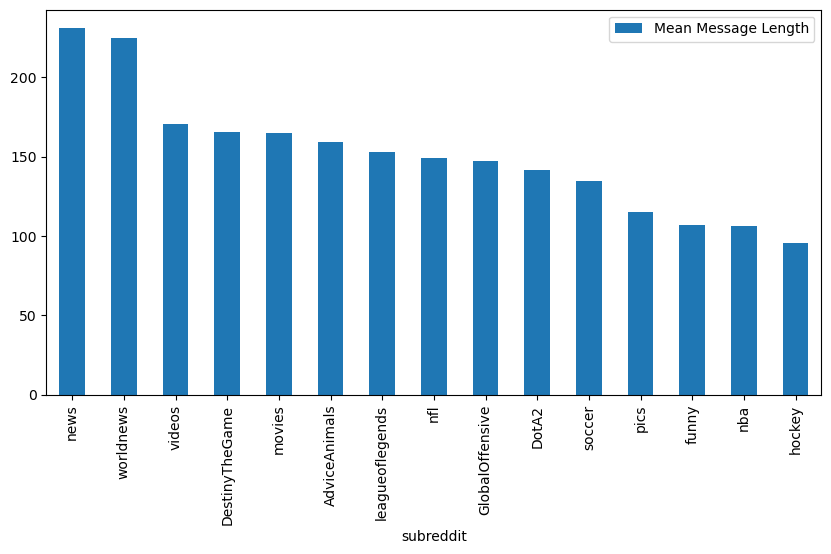

In [28]:
mean_len.plot(kind="bar", x="subreddit", y="Mean Message Length", figsize=(10, 5))

### B1.3. Identify the subreddit with the highest average score

Print the list of subreddits sorted by their average content scores.

/Users/schif/anaconda3/envs/ml_env/lib/python3.11/site-packages/pyspark/sql/dataframe.py:329: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  warnings.warn("Deprecated in 2.0, use createOrReplaceTempView instead.", FutureWarning)


+-------------+------------------+
|    subreddit|         avg_score|
+-------------+------------------+
|       videos|12.649445152612358|
|         pics|12.216559020162904|
|        funny|12.041505399058655|
|AdviceAnimals|11.251695791717447|
|       soccer|10.634627593554693|
|       movies|  9.82014997137628|
|          nfl| 9.048348913155358|
|          nba| 9.032795071943161|
|         news| 8.673421150697779|
|    worldnews|  7.86683719564787|
+-------------+------------------+
only showing top 10 rows



<Axes: xlabel='subreddit'>

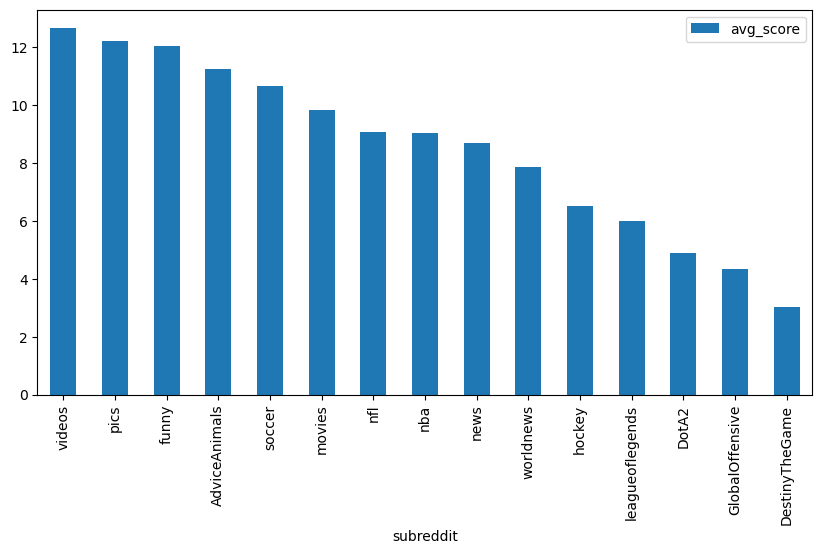

In [33]:
Reddit_Posts.registerTempTable("Reddit_Posts")
Reddit_Scores.registerTempTable("Reddit_Scores")

query = """
SELECT subreddit, AVG(score) as avg_score
FROM Reddit_Scores s JOIN Reddit_Posts p
ON s.id = p.id
GROUP BY subreddit
ORDER BY avg_score DESC
"""

missions_counts = spark.sql(query)
missions_counts.show(10)
missions_counts.toPandas().plot(kind="bar", x="subreddit", y="avg_score", figsize=(10, 5))

## B2. Moderator assignment based on Subreddit Textual Content

Different subreddits follow different communication styles inherent in the topic and the community. Having said that, the goal is to discover similar subreddits by only looking at the *words* present in the posted messages. Once such a list of similar subreddits is identified, an appropriately chosen moderator can then be assigned to all these subreddits.

Specifically, the task boils down to computing a similarity score between two subreddits based on the *words* present in their textual content. Your first idea is to use the *Jaccard similarity*, which is defined as the size of the intersection of two sets divided by the size of their union.

$Jaccard(A,B) = \frac{|A \cap B|}{|A \cup B|}$

In [34]:
def jaccard_similarity(list1, list2):
    s1 = set(list1)
    s2 = set(list2)
    return len(s1.intersection(s2)) / len(s1.union(s2))

### B2.1.
The first step requires constructing a set representation of each subreddit. The goal is to represent each subreddit as a *set of words* existing in the messages posted on that subreddit. Compute the 50,000 most frequent words across all the provided subreddits. Construct a representation for each subreddit by retaining only the words found in the previously identified set of 50,000 frequent words.

Some rules:
 * Words are defined as tokens matching the regular expression `\W`
 * Remove all the stop-words (English language)

*Note: You might find the [RegexTokenizer](https://spark.apache.org/docs/2.2.0/ml-features.html#tokenizer) and the [StopWordsRemover](https://spark.apache.org/docs/2.2.0/ml-features.html#stopwordsremover) utilities available in the package pyspark.ml useful for this task as they help you in transforming the features and removing stopwords.*

In [36]:
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover
from pyspark.sql.window import Window
from pyspark.sql.functions import rank, col

# tokenize the text
regexTokenizer = RegexTokenizer(inputCol="body", outputCol="all_words", pattern="\\W")
words_reddit = regexTokenizer.transform(Reddit_Posts)

# remove stop words
remover = StopWordsRemover(inputCol="all_words", outputCol="words")
reddit_with_tokens = remover.transform(words_reddit).drop("all_words")

In [37]:
reddit_with_tokens.show(5)

+-----------------+--------------------+-------+---------------+--------------------+
|           author|                body|     id|      subreddit|               words|
+-----------------+--------------------+-------+---------------+--------------------+
|        WyaOfWade|gg this one's ove...|cqug90h|            nba|[gg, one, watch, ...|
|        BEE_REAL_|Nihilum and LG ar...|cqug90p|GlobalOffensive|[nihilum, lg, sig...|
|        SlowRolla|Me too. Same hamm...|cqug916|           pics|   [hammock, fabric]|
|   SenpaiOniichan|well i think new ...|cqug919|leagueoflegends|[well, think, new...|
|backwoodsofcanada|That's something ...|cqug91n|  AdviceAnimals|[something, hear,...|
+-----------------+--------------------+-------+---------------+--------------------+
only showing top 5 rows



In [ ]:
top50k = reddit_with_tokens.select(explode("words").alias("word")).groupBy("word").agg(count("*").alias("word count")).orderBy(desc("word count")).limit(50000)
top50k.show(10)

+------+----------+
|  word|word count|
+------+----------+
|  like|   1018978|
|people|    745031|
|   get|    691349|
|   one|    682820|
| think|    575352|
|     m|    569057|
|    re|    517827|
|   com|    497303|
|  time|    456060|
|  good|    454768|
+------+----------+
only showing top 10 rows



In [46]:
tokens = reddit_with_tokens.select("subreddit", explode("words").alias("word")).distinct()

filtered_tokens = tokens.alias("t").join(top50k, tokens.word==top50k.word).select("t.*")

filtered_tokens

DataFrame[subreddit: string, word: string]

In [47]:
reduce_50k = filtered_tokens.rdd.map(lambda r: (r.subreddit, [r.word])).reduceByKey(lambda a,b: a+b).collect()
for sr in reduce_50k:
    print("Subreddit: {} - Words: {}".format(sr[0], len(sr[1])))

Subreddit: AdviceAnimals - Words: 40972
Subreddit: nfl - Words: 39110
Subreddit: worldnews - Words: 41844
Subreddit: news - Words: 41908
Subreddit: funny - Words: 43324
Subreddit: leagueoflegends - Words: 41988
Subreddit: DestinyTheGame - Words: 35637
Subreddit: videos - Words: 43392
Subreddit: movies - Words: 39368
Subreddit: hockey - Words: 36146
Subreddit: soccer - Words: 38185
Subreddit: GlobalOffensive - Words: 34372
Subreddit: nba - Words: 38227
Subreddit: DotA2 - Words: 36879
Subreddit: pics - Words: 42879


### B2.2.
* Compute the Jaccard similarity between all the subreddits using the set representation obtained in step **B2.1.**, and plot in a heatmap the similarity values of all the pairs of subreddits.
* Analyze this plot and discuss your observations. Do you observe that subreddits corresponding to similar topics possess higher Jaccard similarity?
* Provide detailed interpretations of the obtained results. Specifically,
    - Explain the limitations of your conclusions, and discuss the potential reasons.
    - Explain the potential problems with the Jaccard similarity function.

In [50]:
similarity = []
for sr1 in reduce_50k:
    for sr2 in reduce_50k:
        similarity.append((sr1[0], sr2[0], jaccard_similarity(sr1[1], sr2[1]))) # x and y are the subreddits, z is the similarity


similarity_matrix_50k_words = pd.DataFrame(similarity).pivot(index=0, columns=1, values=2)

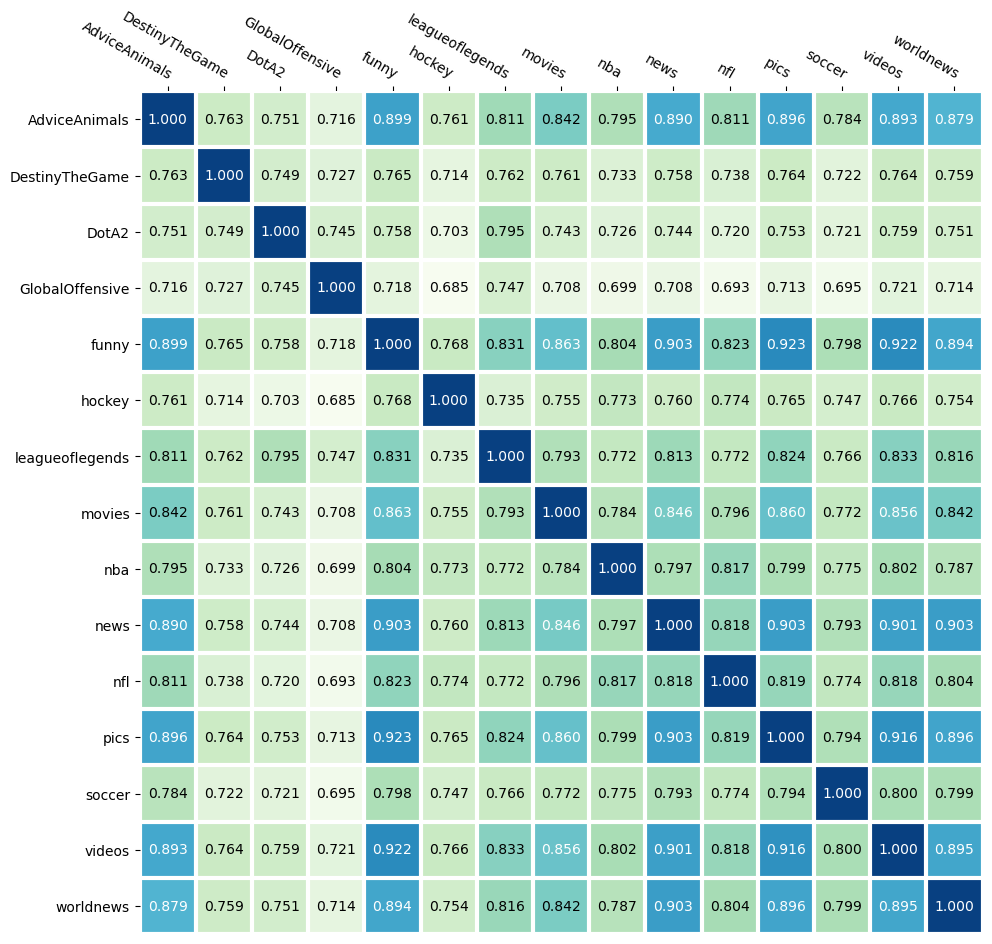

In [52]:
from hw2_utils import plot_heatmap
plot_heatmap(similarity_matrix_50k_words)

### B2.3.

* Alternatively, compute the 1000 most frequent words for each subreddit, construct its representation as the set of top-1000 words, and print a heatmap with the Jaccard similarity like in step **B2.2.**.
* Explain your observations in detail: how and why is this new result different from the one obtained in **B2.2.**?

*Note: Use the same rules specified in B2.1: words tokenized with the regex \W and stop-words removed*

In [59]:
# Word count at subreddit level
words_count_by_subreddit_rdd = reddit_with_tokens.rdd\
    .flatMap(lambda r: [((r.subreddit, w), 1) for w in r.words])\
    .reduceByKey(lambda a,b: a+b).cache()

# conversion in a dataframe
words_count_by_subreddit = spark.createDataFrame(
            words_count_by_subreddit_rdd.map(lambda r: Row(subreddit=r[0][0], word=r[0][1], count=r[1]))
)

# Window on the words grouped by subreddit
window = Window.partitionBy(words_count_by_subreddit['subreddit']).orderBy(col('count').desc())

# Add position with rank() function (rowNumber is accepted, and it would be more correct)
top1000_rdd = words_count_by_subreddit.select('*', rank().over(window).alias('rank'))\
  .filter(col('rank') <= 1000).rdd.map(lambda r: (r.subreddit, [r.word])).reduceByKey(lambda a,b: a+b)

top1000 = top1000_rdd.collect()

Explanation of <br/>
    words_count_by_subreddit_rdd = reddit_with_tokens.rdd\
        .flatMap(lambda r: [((r.subreddit, w), 1) for w in r.words])\
        .reduceByKey(lambda a,b: a+b).cache()

**FlatMap** <br/>
Each record (r) from reddit_with_tokens.rdd is transformed into multiple key-value pairs.
The key is a tuple (r.subreddit, w), where r.subreddit is the subreddit name and w is a word from the list r.words.
The value for each key is 1, indicating the occurrence of the word.

**reduceByKey** <br/>
For each unique key (e.g., (subreddit, word)), the reduceByKey function aggregates the values using the specified function (lambda a, b: a + b).
This function sums up the values for each key, effectively counting the occurrences of each word in a subreddit.

In [ ]:
similarity = []
for sr1 in top1000:
    for sr2 in top1000:
        similarity.append((sr1[0], sr2[0], jaccard_similarity(sr1[1], sr2[1])))


# Crate a dataframe with the similarity
similarity_matrix_words = pd.DataFrame(similarity).pivot(index=0, columns=1, values=2)

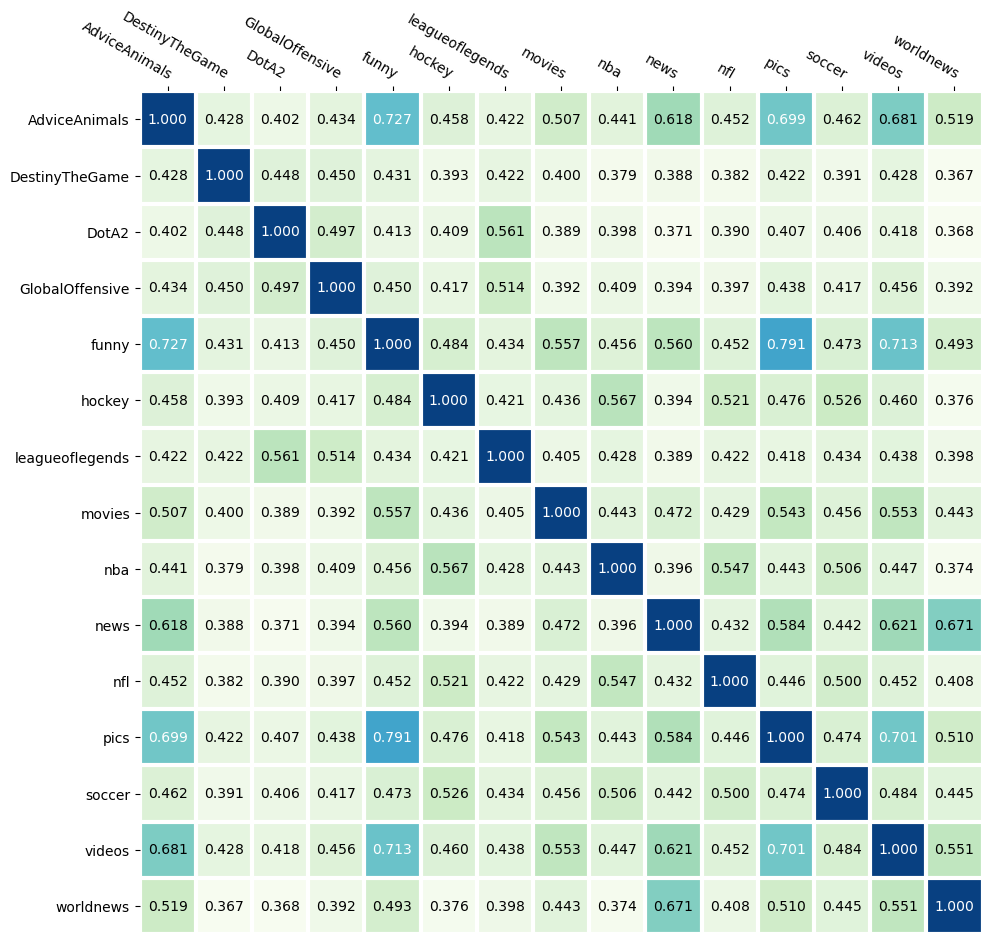

In [61]:
plot_heatmap(similarity_matrix_words)

## B3. Moderator assignment based on Subreddit Users

Subreddits can be seen as communities of people interacting about a common topic. As an alternative to the *textual content* based similarity in **B2**, your task here is to validate if similarity between two subreddits can be measured based on their participating users.

Of course users are not monothematic, and they interact with multiple subreddits. In this task, we are specifically interested in observing the amount of overlap across different subreddits based on their participating users. Similar to **B2**, the overlap is measured using the *Jaccard similarity*.


### B3.1.
Construct a set representation of each subreddit as the users that posted at least one time in that subreddit.

Some users are very talkative and active across different topics. Print the username of the person that posted in the maximum number of subreddits. *Note that users who posted at least once in a subreddit are considered as participant of that subreddit.*

In [55]:
user_in_communities_rdd = Reddit_Posts.select("subreddit", "author").distinct().rdd.map(lambda r: (r.author, 1))\
    .reduceByKey(lambda a,b: a+b).map(lambda r: Row(author=r[0], communities=r[1]))

# Create a dataframe and sort
user_in_communities = spark.createDataFrame(user_in_communities_rdd).sort(col("communities").desc())

user_in_communities.show(1)

+-------+-----------+
| author|communities|
+-------+-----------+
|whispen|         15|
+-------+-----------+
only showing top 1 row



### B3.2.

* Compute the Jaccard similarity between all the subreddits using the set representation obtained in step **B3.1.**, and visualise it similar to **B2**.
* Analyze this plot, identify highly similar pairs of subreddits, and clearly describe your observations.

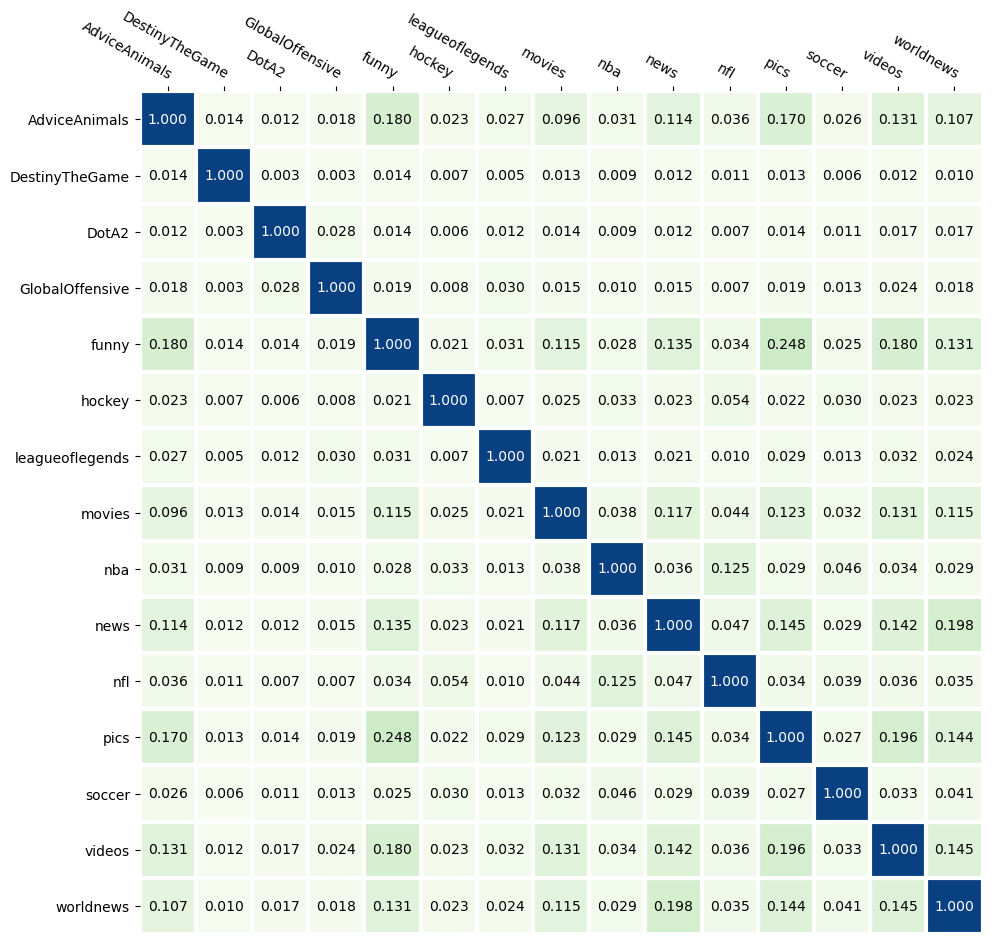

In [62]:
users = Reddit_Posts.select("subreddit", "author").distinct()\
    .rdd.map(lambda r: (r.subreddit, [r.author]))\
    .reduceByKey(lambda a,b: a+b).collect()

similarity_users = []
for sr1 in users:
    for sr2 in users:
        similarity_users.append((sr1[0], sr2[0], jaccard_similarity(sr1[1], sr2[1])))

similarity_matrix_users = pd.DataFrame(similarity_users).pivot(index=0, columns=1, values=2)
plot_heatmap(similarity_matrix_users)

## B4. Language vs. Users similarity
    
* Visualize the similarity scores based on word (**B2.3.**) and user (**B3**) similarity on the x and y axes respectively for the subreddit `NBA` compared to all the other subreddits. Do some semantically meaningful groups emerge? Provide clear explanataions of your observations.
* Furthermore, do you observe differences in similarities between various sports-related subreddits in the dataset? Please provide explanations of the reasons behind these differences, if any!

Text(0.5, 1.0, 'NBA similarity')

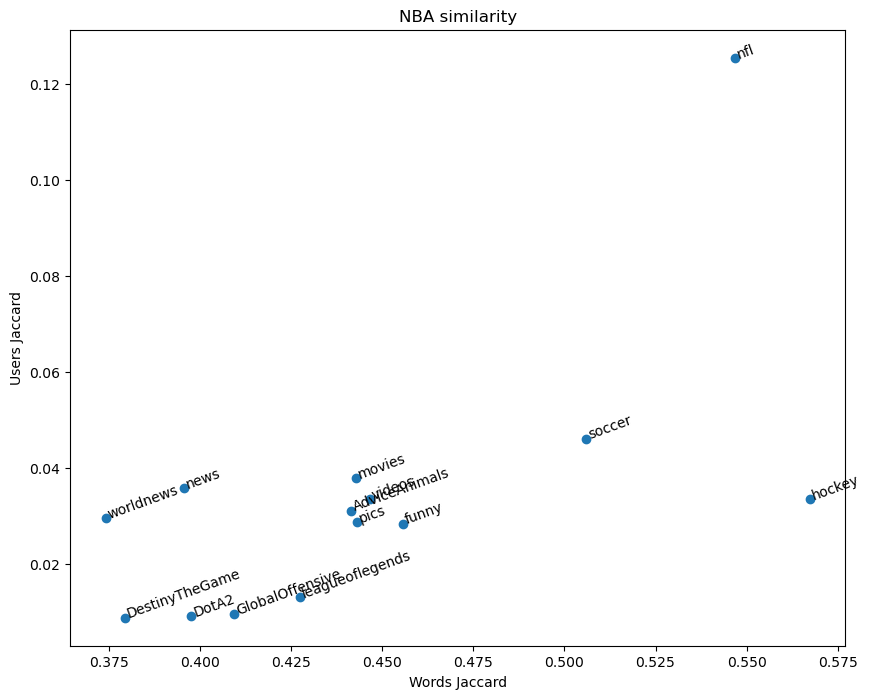

In [72]:
sr = "nba"

fig, ax = plt.subplots(figsize=(10,8))

u = similarity_matrix_users[similarity_matrix_users.index == sr].drop(sr, axis=1).to_numpy()[0]
w = similarity_matrix_words[similarity_matrix_words.index == sr].drop(sr, axis=1).to_numpy()[0]
ax = plt.scatter(w, u)

c=similarity_matrix_users[similarity_matrix_users.index == sr].drop(sr, axis=1).columns.tolist()

for i in range(0, len(u)):
    plt.annotate(c[i], xy=(w[i], u[i]), rotation=20)
    
plt.xlabel("Words Jaccard")
plt.ylabel("Users Jaccard")
plt.title("NBA similarity")

We observe that sports-related subreddits like `nfl`, `soccer`, and `hockey` exhibit higher similarity in both dimensions, reflecting shared audiences and terminology, while non-sports subreddits like `worldnews`, `movies`, and `funny` show lower scores, indicating less thematic overlap.
- NFL and NBA share similar language and many common users, probably due to the fact that they are both very popular in the US 
- Hockey and soccer have a similar overlap in term of users but they differ in language similarity, with hockey the most similar to NBA, probably due to the Canadian influence 